In [240]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,AgglomerativeClustering
from numpy import linalg
import pandas as pd
from sklearn.datasets import load_digits
#import zoopt


In [241]:
#from scipy import optimize
import blackbox as bb

In [242]:
plotting_on = 0
cluster_size = 2
noise_threshold = 10.0
S = 1

In [243]:
def plot_clusters(X, labels):
    chosen_pts_cluster_label = []
    for idx, label in enumerate(labels):
        if label == 0:
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'blue')

        if label == 1:
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'red')

        if mask[idx] == 1:
            chosen_pts_cluster_label.append(label)
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'green')

    if plotting_on:
        plt.show()
    return chosen_pts_cluster_label

def get_Y(labels,n_samples, n_clusters):
    Y = np.zeros([n_samples, n_clusters])
    for idx, label in enumerate(labels):
        Y[idx, label] = 1
    return Y

def run_kmeans(n_clusters, X):
    kmeans = KMeans(n_clusters = n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    
    temp = np.copy(labels)
    temp_c = np.copy(centers)
    if np.sum(centers[0,:]) > np.sum(centers[1,:]):
        return (labels, centers) 
    else:
        labels[temp == 0] = 1
        labels[temp == 1] = 0
        centers[1,:] = temp_c[0,:]
        centers[0,:] = temp_c[1,:]
        return (labels, centers)
    
def run_ward(n_clusters, X):
    ward = AgglomerativeClustering(n_clusters = n_clusters, linkage='ward')
    labels = ward.fit_predict(X)
    #centers = ward.cluster_centers_
    X_temp = np.copy(X)
    center0 = np.zeros((n_features))
    center1 = np.zeros((n_features))
    n_samples0 = 0
    n_samples1 = 0
    for x,l in zip(X_temp, labels):
        if l == 0:
            center0 += x
            n_samples0 += 1.0
        if l == 1:
            center1 += x
            n_samples1 += 1.0

    center0 = center0/float(n_samples0)
    center1 = center1/float(n_samples1)

    centers = np.zeros((2,n_features))
    centers[0,:] = center0
    centers[1,:] = center1
            
    temp = np.copy(labels)
    temp_c = np.copy(centers)
    if np.sum(centers[0,:]) > np.sum(centers[1,:]):
        return (labels, centers) 
    else:
        labels[temp == 0] = 1
        labels[temp == 1] = 0
        centers[1,:] = temp_c[0,:]
        centers[0,:] = temp_c[1,:]
        return (labels, centers)

    
def add_noise(X,noise):
    for i,(m,_) in enumerate(zip(mask,X)):
        if m != 0:
            X[i,:] = X[i,:] + noise
    return X

def get_dist(Y,Y_dash):
    dist = linalg.norm(np.matmul(Y,Y.T) - np.matmul(Y_dash,Y_dash.T))
    return dist


In [244]:
digits = load_digits()
data = digits.data
y = digits.target
X1 = data[y == 0, :]
X2 = data[y == 6,:]
X = np.vstack((X1,X2))

sample_size = X.shape[0]
mask = np.zeros((sample_size))
n_features = X.shape[1]

X_org = np.copy(X)

##kmeans_d = KMeans(n_clusters = cluster_size, random_state=42)
##labels_d = kmeans_d.fit_predict(X)    
##centers_d = kmeans_d.cluster_centers_

ward_d = AgglomerativeClustering(n_clusters = cluster_size, linkage='ward')
labels_d = ward_d.fit_predict(X)    
X_temp_d = np.copy(X)
center0_d = np.zeros((n_features))
center1_d = np.zeros((n_features))
n_samples0_d = 0
n_samples1_d = 0
for x,l in zip(X_temp_d, labels_d):
    if l == 0:
        center0_d += x
        n_samples0_d += 1.0
    if l == 1:
        center1_d += x
        n_samples1_d += 1.0
center0_d = center0_d/float(n_samples0_d)
center1_d = center1_d/float(n_samples1_d)
centers_d = np.zeros((2,n_features))
centers_d[0,:] = center0_d
centers_d[1,:] = center1_d

temp_d = np.copy(labels_d)
temp_c_d = np.copy(centers_d)
if np.sum(centers_d[0,:]) < np.sum(centers_d[1,:]):
    labels_d[temp_d == 0] = 1
    labels_d[temp_d == 1] = 0
    centers_d[1,:] = temp_c_d[0,:]
    centers_d[0,:] = temp_c_d[1,:]


best_vals = []
for idx,label in enumerate(labels_d):
    if label == 0:
        best_vals.append(linalg.norm(X[idx,:] - centers_d[1,:]))
    else:
        best_vals.append(1000000)

best_vals = np.array(best_vals)
best_vals_idx = np.argsort(best_vals)

count = 0
mask_idx = -1
for idx in range(0,sample_size):
    if idx in best_vals_idx[:S]:
        mask[idx] = 1
        count+=1
        mask_idx = idx


In [245]:
def f(x):
    success = 0.0
    noise = np.array(x)
    (labels, centers) = run_ward(cluster_size, X_org)
    org_label = labels[mask_idx]
    Y = get_Y(labels, sample_size, cluster_size)
    X_noisy = np.copy(X_org)
    X_noisy  = add_noise(X_noisy, noise)
    (labels_dash, centers_dash) = run_ward(cluster_size, X_noisy)
    noisy_label = labels_dash[mask_idx]
    Y_dash = get_Y(labels_dash, sample_size, cluster_size)  
    dist = get_dist(Y,Y_dash)
    #if noisy_label != org_label and dist != 0.0:
    #    return -10000.0 - dist
    #else:
    #    return 1000000.0
    #    success = 1.0
    #return (linalg.norm(noise)-(dist + 10000*success))
    if dist != 0.0:
        #return -dist + linalg.norm(noise)
        return -dist
    else:
        return 1000000.0

In [246]:
bb.search(f=f,  # given function
          box=[[-5, 5]]*64,  # range of values for each parameter (2D case)
          n=40,  # number of function calls on initial stage (global search)
          m=40,  # number of function calls on subsequent stage (local search)
          batch=4,  # number of calls that will be evaluated in parallel
          resfile='output_new.csv')  # text file where results will be saved

In [247]:
best_noise = [ -2.1378e-01, -4.2528e-01, -6.3452e-01, -8.4152e-01, -1.0463e+00, -1.2489e+00, -1.4493e+00, -1.6476e+00, -1.8438e+00, -2.0379e+00, -2.2299e+00, -2.4198e+00, -2.6077e+00, -2.7936e+00, -2.9776e+00, -3.1595e+00, -3.3395e+00, -3.5176e+00, -3.6938e+00, -3.8681e+00, -4.0405e+00, -4.2111e+00, -4.3799e+00, -4.5469e+00, -4.7120e+00, -4.8755e+00, +4.9629e+00, +4.8029e+00, +4.6447e+00, +4.4882e+00, +4.3333e+00, +4.1801e+00, +4.0285e+00, +3.8786e+00, +3.7302e+00, +3.5834e+00, +3.4382e+00, +3.2946e+00, +3.1525e+00, +3.0119e+00, +2.8728e+00, +2.7352e+00, +2.5991e+00, +2.4644e+00, +2.3312e+00, +2.1994e+00, +2.0690e+00, +1.9400e+00, +1.8123e+00, +1.6861e+00, +1.5612e+00, +1.4376e+00, +1.3153e+00, +1.1944e+00, +1.0747e+00, +9.5633e-01, +8.3922e-01, +7.2336e-01, +6.0873e-01, +4.9533e-01, +3.8315e-01, +2.7216e-01, +1.6236e-01, +5.3733e-02]
np.save('wip2_X_org.npy', X_org)
X_adv = np.copy(X_org)
X_adv = add_noise(X_adv, best_noise)
np.save('wip2_X_adv.npy', X_adv)
print(mask_idx)

160


In [248]:
Xo = np.load('wip2_X_org.npy')
Xa = np.load('wip2_X_adv.npy')

lo,_ = run_ward(2, Xo)
la,_ = run_ward(2, Xa)

In [249]:
print(lo,la)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [250]:
print(lo[lo == 0].shape, lo[lo == 1].shape)
print(lo[mask_idx],la[mask_idx])

((178,), (181,))
(0, 0)


In [251]:
count_diffs = 0
perturbed_idx = []
for idx,(el1, el2) in enumerate(zip(lo,la)):
    if el1 != el2:
        count_diffs += 1
        perturbed_idx.append(idx)
print(count_diffs)

3


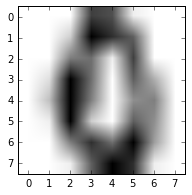

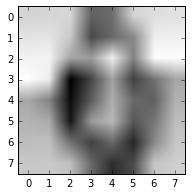

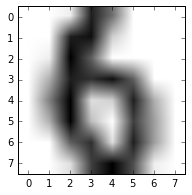

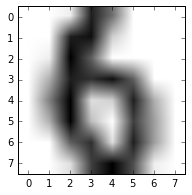

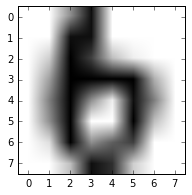

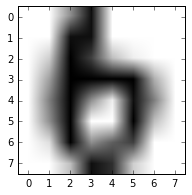

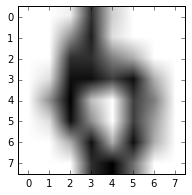

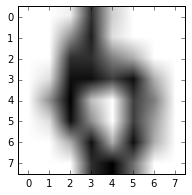

In [252]:
for idx, (org,noisy) in enumerate(zip(Xo, Xa)):
    if idx in perturbed_idx or idx == mask_idx:
        plt.figure(1,figsize=(3,3)) ##
        plt.imshow(np.reshape(org,(8,8)), cmap=plt.cm.gray_r) ##
        plt.show() ##
        plt.figure(1,figsize=(3,3)) ##
        plt.imshow(np.reshape(noisy,(8,8)), cmap=plt.cm.gray_r) ##
        plt.show() ##

In [253]:
for i in perturbed_idx:
    print(lo[i], la[i], y[i])

(1, 0, 8)
(1, 0, 0)
(1, 0, 6)


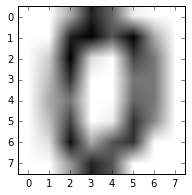

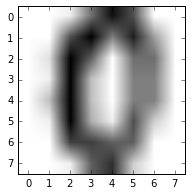

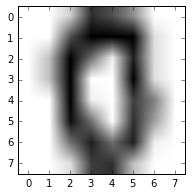

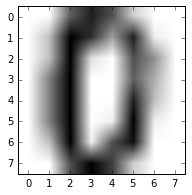

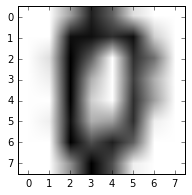

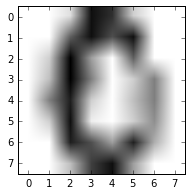

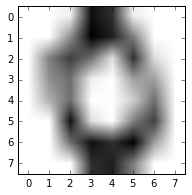

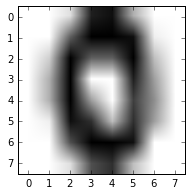

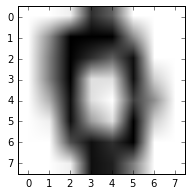

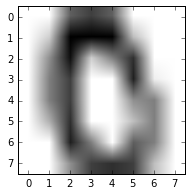

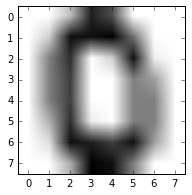

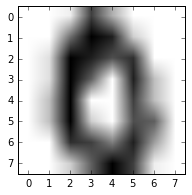

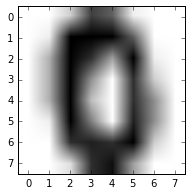

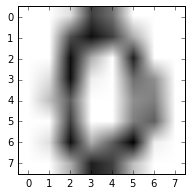

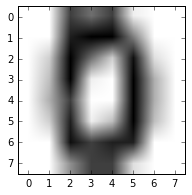

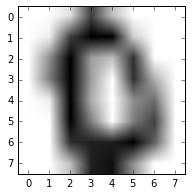

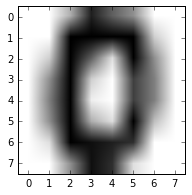

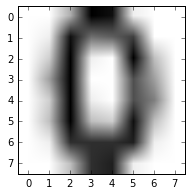

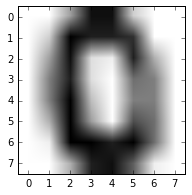

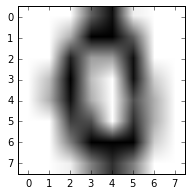

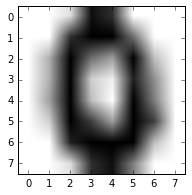

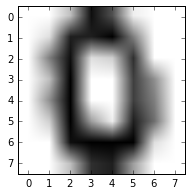

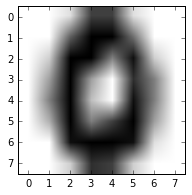

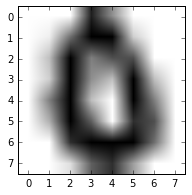

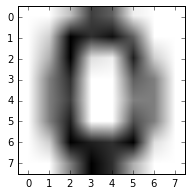

KeyboardInterrupt: 

In [255]:
for i,l in enumerate(lo):
    if l == 0:
        plt.figure(1,figsize=(3,3)) ##
        plt.imshow(np.reshape(Xo[i,:],(8,8)), cmap=plt.cm.gray_r) ##
        plt.show() ##